# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from modeling import read_data_for_training, \
                     create_linear_architecture, \
                     compile_linear_model, \
                     train_linear_model, \
                     plot_model_history, \
                     store_model

2023-09-27 16:19:36.432412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 16:19:37.034150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Define constants

This section defines constants to specify the location of the data and where the model will be stored

In [2]:
# Path to the files where the data for the training is
features_filename = "surfaces_linear"
labels_filename = "coefficients_linear"

# 2. Read data

Get train, validation and test data

In [3]:
train_features, \
train_labels, \
val_features, \
val_labels, \
test_features, \
test_labels = read_data_for_training(features_filename,
                                     labels_filename)

# 3. Define hyperparameters for neural network

In the first place define the hyperparameters of the neural network

In [4]:
# Neural network architecture hyperparameters
input_shape = train_features[0].shape
output_size = len(train_labels[0])
hidden_layer_sizes = [1024, 512, 256, 64, 32]
regularizer = keras.regularizers.L1L2(l1=0.001,l2=0.1)
hidden_activation = 'relu'
output_activation = 'linear'
use_batch_normalization = True
name = 'BigLinearModel'

# Compilation hyperparameters
loss_function = tf.keras.losses.MeanSquaredError()
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
metric = tf.keras.metrics.MeanSquaredError()

# Training hyperparameters
epochs = 2000
batch_size = 64
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=150, verbose=1)
early_stop = EarlyStopping('mean_squared_error', patience=500, verbose=1)
callbacks = [reduce_lr, early_stop]

2023-09-27 11:55:24.434294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 11:55:24.454812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 11:55:24.454993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 4. Train Network

Create the architecture

In [5]:
surface_reconstructor_model = create_linear_architecture(input_shape,
                                                         output_size,
                                                         hidden_layer_sizes,
                                                         regularizer,
                                                         hidden_activation,
                                                         output_activation,
                                                         use_batch_normalization=use_batch_normalization,
                                                         name=name)

Compile the model

In [6]:
compile_linear_model(surface_reconstructor_model,
                     loss_function,
                     optimizer,
                     metric
                     )

Fit the model

In [7]:
history = train_linear_model(surface_reconstructor_model,
                             train_features,
                             train_labels,
                             batch_size,
                             epochs,
                             val_features,
                             val_labels,
                             callbacks)

Epoch 1/2000


2023-09-27 11:55:27.015754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-27 11:55:27.017710: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f80d1ec4610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-27 11:55:27.017731: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-09-27 11:55:27.021185: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-27 11:55:27.143696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-27 11:55:27.248206: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

750/750 [==============================] - 10s 9ms/step - loss: 29.4269 - mean_squared_error: 16.7736 - val_loss: 23.0010 - val_mean_squared_error: 20.4257 - lr: 0.0100
Epoch 2/2000
750/750 [==============================] - 6s 8ms/step - loss: 15.0489 - mean_squared_error: 13.2316 - val_loss: 22.6108 - val_mean_squared_error: 21.1746 - lr: 0.0100
Epoch 3/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.8833 - mean_squared_error: 12.5488 - val_loss: 23.7285 - val_mean_squared_error: 22.4116 - lr: 0.0100
Epoch 4/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.6601 - mean_squared_error: 12.3432 - val_loss: 19.9457 - val_mean_squared_error: 18.5350 - lr: 0.0100
Epoch 5/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.6657 - mean_squared_error: 12.2732 - val_loss: 19.0845 - val_mean_squared_error: 17.7002 - lr: 0.0100
Epoch 6/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.6528 - mean_squared_error: 1

750/750 [==============================] - 6s 8ms/step - loss: 13.7272 - mean_squared_error: 12.0636 - val_loss: 82.0025 - val_mean_squared_error: 80.3560 - lr: 0.0100
Epoch 92/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7145 - mean_squared_error: 12.0649 - val_loss: 35.5304 - val_mean_squared_error: 33.8450 - lr: 0.0100
Epoch 93/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7392 - mean_squared_error: 12.0752 - val_loss: 25.9141 - val_mean_squared_error: 24.2577 - lr: 0.0100
Epoch 94/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7281 - mean_squared_error: 12.0632 - val_loss: 32.8351 - val_mean_squared_error: 31.1777 - lr: 0.0100
Epoch 95/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7508 - mean_squared_error: 12.0838 - val_loss: 26.0015 - val_mean_squared_error: 24.3691 - lr: 0.0100
Epoch 96/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7775 - mean_squared_erro

Epoch 136/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7150 - mean_squared_error: 12.0563 - val_loss: 28.1273 - val_mean_squared_error: 26.4621 - lr: 0.0100
Epoch 137/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7450 - mean_squared_error: 12.0775 - val_loss: 34.1768 - val_mean_squared_error: 32.5056 - lr: 0.0100
Epoch 138/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7584 - mean_squared_error: 12.0938 - val_loss: 25.2593 - val_mean_squared_error: 23.6506 - lr: 0.0100
Epoch 139/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7777 - mean_squared_error: 12.0984 - val_loss: 40.6967 - val_mean_squared_error: 39.0437 - lr: 0.0100
Epoch 140/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7808 - mean_squared_error: 12.1130 - val_loss: 44.1492 - val_mean_squared_error: 42.4672 - lr: 0.0100
Epoch 141/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7685

Epoch 181/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.6953 - mean_squared_error: 12.0498 - val_loss: 31.7051 - val_mean_squared_error: 30.0831 - lr: 0.0100
Epoch 182/2000
750/750 [==============================] - 5s 6ms/step - loss: 13.7596 - mean_squared_error: 12.0867 - val_loss: 29.7411 - val_mean_squared_error: 28.0894 - lr: 0.0100
Epoch 183/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7416 - mean_squared_error: 12.0803 - val_loss: 34.9296 - val_mean_squared_error: 33.2623 - lr: 0.0100
Epoch 184/2000
750/750 [==============================] - 6s 8ms/step - loss: 13.7928 - mean_squared_error: 12.1172 - val_loss: 28.9934 - val_mean_squared_error: 27.2866 - lr: 0.0100
Epoch 185/2000
750/750 [==============================] - 6s 9ms/step - loss: 13.7663 - mean_squared_error: 12.1005 - val_loss: 36.8718 - val_mean_squared_error: 35.1948 - lr: 0.0100
Epoch 186/2000
750/750 [==============================] - 7s 9ms/step - loss: 13.7508

750/750 [==============================] - 7s 9ms/step - loss: 11.6582 - mean_squared_error: 11.4375 - val_loss: 12.8910 - val_mean_squared_error: 12.6687 - lr: 1.0000e-03
Epoch 225/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6639 - mean_squared_error: 11.4440 - val_loss: 16.1224 - val_mean_squared_error: 15.8795 - lr: 1.0000e-03
Epoch 226/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6699 - mean_squared_error: 11.4493 - val_loss: 14.6655 - val_mean_squared_error: 14.4488 - lr: 1.0000e-03
Epoch 227/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6597 - mean_squared_error: 11.4412 - val_loss: 14.2703 - val_mean_squared_error: 14.0255 - lr: 1.0000e-03
Epoch 228/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6594 - mean_squared_error: 11.4403 - val_loss: 12.4614 - val_mean_squared_error: 12.2463 - lr: 1.0000e-03
Epoch 229/2000
750/750 [==============================] - 7s 9ms/step - loss: 11

Epoch 268/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6530 - mean_squared_error: 11.4262 - val_loss: 14.3148 - val_mean_squared_error: 14.0864 - lr: 1.0000e-03
Epoch 269/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6481 - mean_squared_error: 11.4237 - val_loss: 14.5151 - val_mean_squared_error: 14.2636 - lr: 1.0000e-03
Epoch 270/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6537 - mean_squared_error: 11.4290 - val_loss: 19.3227 - val_mean_squared_error: 19.0996 - lr: 1.0000e-03
Epoch 271/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6553 - mean_squared_error: 11.4300 - val_loss: 13.5889 - val_mean_squared_error: 13.3384 - lr: 1.0000e-03
Epoch 272/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6597 - mean_squared_error: 11.4323 - val_loss: 17.3924 - val_mean_squared_error: 17.1665 - lr: 1.0000e-03
Epoch 273/2000
750/750 [==============================] - 6s 9ms/

Epoch 312/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6511 - mean_squared_error: 11.4193 - val_loss: 16.8514 - val_mean_squared_error: 16.6209 - lr: 1.0000e-03
Epoch 313/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6316 - mean_squared_error: 11.3996 - val_loss: 14.3422 - val_mean_squared_error: 14.0866 - lr: 1.0000e-03
Epoch 314/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6378 - mean_squared_error: 11.4065 - val_loss: 14.7735 - val_mean_squared_error: 14.5431 - lr: 1.0000e-03
Epoch 315/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6334 - mean_squared_error: 11.4012 - val_loss: 15.5985 - val_mean_squared_error: 15.3465 - lr: 1.0000e-03
Epoch 316/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6346 - mean_squared_error: 11.4056 - val_loss: 18.6738 - val_mean_squared_error: 18.4448 - lr: 1.0000e-03
Epoch 317/2000
750/750 [==============================] - 6s 9ms/

Epoch 356/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6340 - mean_squared_error: 11.3958 - val_loss: 17.9082 - val_mean_squared_error: 17.6676 - lr: 1.0000e-03
Epoch 357/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6207 - mean_squared_error: 11.3845 - val_loss: 16.2206 - val_mean_squared_error: 15.9568 - lr: 1.0000e-03
Epoch 358/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6313 - mean_squared_error: 11.3937 - val_loss: 13.4394 - val_mean_squared_error: 13.2072 - lr: 1.0000e-03
Epoch 359/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6301 - mean_squared_error: 11.3931 - val_loss: 18.4822 - val_mean_squared_error: 18.2166 - lr: 1.0000e-03
Epoch 360/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6104 - mean_squared_error: 11.3736 - val_loss: 13.6419 - val_mean_squared_error: 13.4072 - lr: 1.0000e-03
Epoch 361/2000
750/750 [==============================] - 7s 9ms/

Epoch 400/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6146 - mean_squared_error: 11.3745 - val_loss: 14.5852 - val_mean_squared_error: 14.3492 - lr: 1.0000e-03
Epoch 401/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6259 - mean_squared_error: 11.3851 - val_loss: 28.1144 - val_mean_squared_error: 27.8467 - lr: 1.0000e-03
Epoch 402/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6189 - mean_squared_error: 11.3781 - val_loss: 15.7822 - val_mean_squared_error: 15.5428 - lr: 1.0000e-03
Epoch 403/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6288 - mean_squared_error: 11.3878 - val_loss: 13.7994 - val_mean_squared_error: 13.5327 - lr: 1.0000e-03
Epoch 404/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6178 - mean_squared_error: 11.3790 - val_loss: 12.7079 - val_mean_squared_error: 12.4730 - lr: 1.0000e-03
Epoch 405/2000
750/750 [==============================] - 6s 8ms/

Epoch 444/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6122 - mean_squared_error: 11.3681 - val_loss: 21.7008 - val_mean_squared_error: 21.4599 - lr: 1.0000e-03
Epoch 445/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6103 - mean_squared_error: 11.3671 - val_loss: 14.1578 - val_mean_squared_error: 13.8884 - lr: 1.0000e-03
Epoch 446/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6277 - mean_squared_error: 11.3844 - val_loss: 16.8275 - val_mean_squared_error: 16.5854 - lr: 1.0000e-03
Epoch 447/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6124 - mean_squared_error: 11.3683 - val_loss: 16.9300 - val_mean_squared_error: 16.6595 - lr: 1.0000e-03
Epoch 448/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6073 - mean_squared_error: 11.3647 - val_loss: 20.2719 - val_mean_squared_error: 20.0293 - lr: 1.0000e-03
Epoch 449/2000
750/750 [==============================] - 6s 9ms/

Epoch 488/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6063 - mean_squared_error: 11.3593 - val_loss: 18.6051 - val_mean_squared_error: 18.3632 - lr: 1.0000e-03
Epoch 489/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6146 - mean_squared_error: 11.3667 - val_loss: 15.1034 - val_mean_squared_error: 14.8289 - lr: 1.0000e-03
Epoch 490/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6083 - mean_squared_error: 11.3596 - val_loss: 15.5405 - val_mean_squared_error: 15.2935 - lr: 1.0000e-03
Epoch 491/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6010 - mean_squared_error: 11.3546 - val_loss: 19.8709 - val_mean_squared_error: 19.6023 - lr: 1.0000e-03
Epoch 492/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5988 - mean_squared_error: 11.3509 - val_loss: 31.9558 - val_mean_squared_error: 31.7069 - lr: 1.0000e-03
Epoch 493/2000
750/750 [==============================] - 6s 9ms/

Epoch 532/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6098 - mean_squared_error: 11.3595 - val_loss: 25.4943 - val_mean_squared_error: 25.2414 - lr: 1.0000e-03
Epoch 533/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6124 - mean_squared_error: 11.3607 - val_loss: 21.4299 - val_mean_squared_error: 21.1543 - lr: 1.0000e-03
Epoch 534/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6033 - mean_squared_error: 11.3534 - val_loss: 15.3153 - val_mean_squared_error: 15.0644 - lr: 1.0000e-03
Epoch 535/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6077 - mean_squared_error: 11.3556 - val_loss: 22.6696 - val_mean_squared_error: 22.3875 - lr: 1.0000e-03
Epoch 536/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6107 - mean_squared_error: 11.3586 - val_loss: 15.0148 - val_mean_squared_error: 14.7644 - lr: 1.0000e-03
Epoch 537/2000
750/750 [==============================] - 7s 9ms/

Epoch 576/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5983 - mean_squared_error: 11.3447 - val_loss: 21.3445 - val_mean_squared_error: 21.0938 - lr: 1.0000e-03
Epoch 577/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5972 - mean_squared_error: 11.3454 - val_loss: 21.5203 - val_mean_squared_error: 21.2397 - lr: 1.0000e-03
Epoch 578/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6097 - mean_squared_error: 11.3563 - val_loss: 17.3762 - val_mean_squared_error: 17.1231 - lr: 1.0000e-03
Epoch 579/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6053 - mean_squared_error: 11.3523 - val_loss: 24.2023 - val_mean_squared_error: 23.9262 - lr: 1.0000e-03
Epoch 580/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5976 - mean_squared_error: 11.3443 - val_loss: 14.9676 - val_mean_squared_error: 14.7181 - lr: 1.0000e-03
Epoch 581/2000
750/750 [==============================] - 7s 9ms/

Epoch 620/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6030 - mean_squared_error: 11.3477 - val_loss: 17.6443 - val_mean_squared_error: 17.3891 - lr: 1.0000e-03
Epoch 621/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6105 - mean_squared_error: 11.3550 - val_loss: 15.6576 - val_mean_squared_error: 15.3776 - lr: 1.0000e-03
Epoch 622/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6103 - mean_squared_error: 11.3546 - val_loss: 13.5798 - val_mean_squared_error: 13.3231 - lr: 1.0000e-03
Epoch 623/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6014 - mean_squared_error: 11.3460 - val_loss: 18.3769 - val_mean_squared_error: 18.0970 - lr: 1.0000e-03
Epoch 624/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6022 - mean_squared_error: 11.3451 - val_loss: 18.9370 - val_mean_squared_error: 18.6816 - lr: 1.0000e-03
Epoch 625/2000
750/750 [==============================] - 7s 9ms/

Epoch 664/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5980 - mean_squared_error: 11.3401 - val_loss: 19.9027 - val_mean_squared_error: 19.6489 - lr: 1.0000e-03
Epoch 665/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6194 - mean_squared_error: 11.3610 - val_loss: 16.0998 - val_mean_squared_error: 15.8172 - lr: 1.0000e-03
Epoch 666/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6009 - mean_squared_error: 11.3422 - val_loss: 25.5161 - val_mean_squared_error: 25.2594 - lr: 1.0000e-03
Epoch 667/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.5982 - mean_squared_error: 11.3415 - val_loss: 14.7979 - val_mean_squared_error: 14.5157 - lr: 1.0000e-03
Epoch 668/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6082 - mean_squared_error: 11.3507 - val_loss: 17.4474 - val_mean_squared_error: 17.1890 - lr: 1.0000e-03
Epoch 669/2000
750/750 [==============================] - 7s 9ms/

Epoch 708/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6104 - mean_squared_error: 11.3527 - val_loss: 19.0782 - val_mean_squared_error: 18.8222 - lr: 1.0000e-03
Epoch 709/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6028 - mean_squared_error: 11.3440 - val_loss: 17.2794 - val_mean_squared_error: 16.9946 - lr: 1.0000e-03
Epoch 710/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5982 - mean_squared_error: 11.3398 - val_loss: 16.9934 - val_mean_squared_error: 16.7376 - lr: 1.0000e-03
Epoch 711/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6095 - mean_squared_error: 11.3500 - val_loss: 19.2085 - val_mean_squared_error: 18.9237 - lr: 1.0000e-03
Epoch 712/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6072 - mean_squared_error: 11.3475 - val_loss: 15.9425 - val_mean_squared_error: 15.6820 - lr: 1.0000e-03
Epoch 713/2000
750/750 [==============================] - 7s 9ms/

Epoch 752/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6102 - mean_squared_error: 11.3484 - val_loss: 20.3001 - val_mean_squared_error: 20.0368 - lr: 1.0000e-03
Epoch 753/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5990 - mean_squared_error: 11.3392 - val_loss: 23.5334 - val_mean_squared_error: 23.2489 - lr: 1.0000e-03
Epoch 754/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5958 - mean_squared_error: 11.3366 - val_loss: 19.9259 - val_mean_squared_error: 19.6689 - lr: 1.0000e-03
Epoch 755/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6060 - mean_squared_error: 11.3478 - val_loss: 19.2385 - val_mean_squared_error: 18.9529 - lr: 1.0000e-03
Epoch 756/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.5974 - mean_squared_error: 11.3381 - val_loss: 13.6973 - val_mean_squared_error: 13.4370 - lr: 1.0000e-03
Epoch 757/2000
750/750 [==============================] - 6s 8ms/

Epoch 796/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5950 - mean_squared_error: 11.3345 - val_loss: 14.1958 - val_mean_squared_error: 13.9364 - lr: 1.0000e-03
Epoch 797/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6034 - mean_squared_error: 11.3422 - val_loss: 18.9118 - val_mean_squared_error: 18.6223 - lr: 1.0000e-03
Epoch 798/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5918 - mean_squared_error: 11.3308 - val_loss: 24.0303 - val_mean_squared_error: 23.7730 - lr: 1.0000e-03
Epoch 799/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6021 - mean_squared_error: 11.3413 - val_loss: 24.1356 - val_mean_squared_error: 23.8497 - lr: 1.0000e-03
Epoch 800/2000
750/750 [==============================] - 4s 6ms/step - loss: 11.5962 - mean_squared_error: 11.3356 - val_loss: 13.8064 - val_mean_squared_error: 13.5441 - lr: 1.0000e-03
Epoch 801/2000
750/750 [==============================] - 6s 8ms/

Epoch 840/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5949 - mean_squared_error: 11.3334 - val_loss: 20.7599 - val_mean_squared_error: 20.4995 - lr: 1.0000e-03
Epoch 841/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6017 - mean_squared_error: 11.3422 - val_loss: 15.4822 - val_mean_squared_error: 15.1957 - lr: 1.0000e-03
Epoch 842/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6021 - mean_squared_error: 11.3410 - val_loss: 18.2675 - val_mean_squared_error: 18.0060 - lr: 1.0000e-03
Epoch 843/2000
750/750 [==============================] - 6s 9ms/step - loss: 11.6042 - mean_squared_error: 11.3423 - val_loss: 16.4966 - val_mean_squared_error: 16.2121 - lr: 1.0000e-03
Epoch 844/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6138 - mean_squared_error: 11.3527 - val_loss: 19.0946 - val_mean_squared_error: 18.8346 - lr: 1.0000e-03
Epoch 845/2000
750/750 [==============================] - 7s 9ms/

Epoch 884/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5952 - mean_squared_error: 11.3335 - val_loss: 20.4813 - val_mean_squared_error: 20.2198 - lr: 1.0000e-03
Epoch 885/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6005 - mean_squared_error: 11.3403 - val_loss: 14.3759 - val_mean_squared_error: 14.0932 - lr: 1.0000e-03
Epoch 886/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5923 - mean_squared_error: 11.3333 - val_loss: 17.7091 - val_mean_squared_error: 17.4531 - lr: 1.0000e-03
Epoch 887/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.6082 - mean_squared_error: 11.3469 - val_loss: 14.1808 - val_mean_squared_error: 13.8937 - lr: 1.0000e-03
Epoch 888/2000
750/750 [==============================] - 7s 9ms/step - loss: 11.5947 - mean_squared_error: 11.3359 - val_loss: 29.4577 - val_mean_squared_error: 29.2003 - lr: 1.0000e-03
Epoch 889/2000
750/750 [==============================] - 6s 8ms/

Epoch 928/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.5959 - mean_squared_error: 11.3348 - val_loss: 22.6004 - val_mean_squared_error: 22.3369 - lr: 1.0000e-03
Epoch 929/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6078 - mean_squared_error: 11.3456 - val_loss: 15.7125 - val_mean_squared_error: 15.4223 - lr: 1.0000e-03
Epoch 930/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6068 - mean_squared_error: 11.3439 - val_loss: 37.0590 - val_mean_squared_error: 36.7972 - lr: 1.0000e-03
Epoch 931/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6043 - mean_squared_error: 11.3427 - val_loss: 19.5759 - val_mean_squared_error: 19.2879 - lr: 1.0000e-03
Epoch 932/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.5921 - mean_squared_error: 11.3317 - val_loss: 24.6528 - val_mean_squared_error: 24.3939 - lr: 1.0000e-03
Epoch 933/2000
750/750 [==============================] - 6s 8ms/

Epoch 972/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6002 - mean_squared_error: 11.3398 - val_loss: 23.2167 - val_mean_squared_error: 22.9545 - lr: 1.0000e-03
Epoch 973/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.5873 - mean_squared_error: 11.3282 - val_loss: 14.9913 - val_mean_squared_error: 14.7080 - lr: 1.0000e-03
Epoch 974/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6030 - mean_squared_error: 11.3420 - val_loss: 14.2377 - val_mean_squared_error: 13.9792 - lr: 1.0000e-03
Epoch 975/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.5947 - mean_squared_error: 11.3346 - val_loss: 22.6475 - val_mean_squared_error: 22.3627 - lr: 1.0000e-03
Epoch 976/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6082 - mean_squared_error: 11.3485 - val_loss: 21.8495 - val_mean_squared_error: 21.5887 - lr: 1.0000e-03
Epoch 977/2000
750/750 [==============================] - 6s 8ms/

Epoch 1016/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.6098 - mean_squared_error: 11.3474 - val_loss: 17.4264 - val_mean_squared_error: 17.1664 - lr: 1.0000e-03
Epoch 1017/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6070 - mean_squared_error: 11.3435 - val_loss: 18.8201 - val_mean_squared_error: 18.5327 - lr: 1.0000e-03
Epoch 1018/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.5982 - mean_squared_error: 11.3369 - val_loss: 16.7923 - val_mean_squared_error: 16.5332 - lr: 1.0000e-03
Epoch 1019/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.5987 - mean_squared_error: 11.3382 - val_loss: 15.0038 - val_mean_squared_error: 14.7180 - lr: 1.0000e-03
Epoch 1020/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6052 - mean_squared_error: 11.3441 - val_loss: 23.9225 - val_mean_squared_error: 23.6622 - lr: 1.0000e-03
Epoch 1021/2000
750/750 [==============================] - 5

Epoch 1103/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.5896 - mean_squared_error: 11.3281 - val_loss: 18.5295 - val_mean_squared_error: 18.2431 - lr: 1.0000e-03
Epoch 1104/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.5918 - mean_squared_error: 11.3318 - val_loss: 27.8882 - val_mean_squared_error: 27.6286 - lr: 1.0000e-03
Epoch 1105/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6009 - mean_squared_error: 11.3406 - val_loss: 19.1590 - val_mean_squared_error: 18.8726 - lr: 1.0000e-03
Epoch 1106/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.6037 - mean_squared_error: 11.3433 - val_loss: 18.6444 - val_mean_squared_error: 18.3830 - lr: 1.0000e-03
Epoch 1107/2000
749/750 [============================>.] - ETA: 0s - loss: 11.5917 - mean_squared_error: 11.3302
Epoch 1107: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
750/750 [==============================] - 5s 7ms/step -

Epoch 1146/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2542 - mean_squared_error: 11.2029 - val_loss: 13.1644 - val_mean_squared_error: 13.1155 - lr: 1.0000e-04
Epoch 1147/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2581 - mean_squared_error: 11.2072 - val_loss: 12.4839 - val_mean_squared_error: 12.4324 - lr: 1.0000e-04
Epoch 1148/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2620 - mean_squared_error: 11.2115 - val_loss: 11.1409 - val_mean_squared_error: 11.0893 - lr: 1.0000e-04
Epoch 1149/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2578 - mean_squared_error: 11.2075 - val_loss: 11.4416 - val_mean_squared_error: 11.3916 - lr: 1.0000e-04
Epoch 1150/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.2589 - mean_squared_error: 11.2088 - val_loss: 12.1791 - val_mean_squared_error: 12.1303 - lr: 1.0000e-04
Epoch 1151/2000
750/750 [==============================] - 6

Epoch 1233/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2620 - mean_squared_error: 11.2170 - val_loss: 11.6095 - val_mean_squared_error: 11.5654 - lr: 1.0000e-04
Epoch 1234/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2525 - mean_squared_error: 11.2076 - val_loss: 11.5806 - val_mean_squared_error: 11.5371 - lr: 1.0000e-04
Epoch 1235/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2563 - mean_squared_error: 11.2114 - val_loss: 11.1974 - val_mean_squared_error: 11.1495 - lr: 1.0000e-04
Epoch 1236/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2559 - mean_squared_error: 11.2110 - val_loss: 11.5337 - val_mean_squared_error: 11.4917 - lr: 1.0000e-04
Epoch 1237/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2559 - mean_squared_error: 11.2110 - val_loss: 11.1458 - val_mean_squared_error: 11.1009 - lr: 1.0000e-04
Epoch 1238/2000
750/750 [==============================] - 5

Epoch 1320/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2540 - mean_squared_error: 11.2095 - val_loss: 11.8292 - val_mean_squared_error: 11.7881 - lr: 1.0000e-04
Epoch 1321/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2557 - mean_squared_error: 11.2112 - val_loss: 12.4878 - val_mean_squared_error: 12.4438 - lr: 1.0000e-04
Epoch 1322/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2495 - mean_squared_error: 11.2050 - val_loss: 11.9818 - val_mean_squared_error: 11.9352 - lr: 1.0000e-04
Epoch 1323/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2501 - mean_squared_error: 11.2057 - val_loss: 11.2256 - val_mean_squared_error: 11.1829 - lr: 1.0000e-04
Epoch 1324/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2522 - mean_squared_error: 11.2079 - val_loss: 11.6470 - val_mean_squared_error: 11.6049 - lr: 1.0000e-04
Epoch 1325/2000
750/750 [==============================] - 5

Epoch 1407/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2522 - mean_squared_error: 11.2076 - val_loss: 11.6643 - val_mean_squared_error: 11.6194 - lr: 1.0000e-04
Epoch 1408/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2538 - mean_squared_error: 11.2091 - val_loss: 11.2386 - val_mean_squared_error: 11.1966 - lr: 1.0000e-04
Epoch 1409/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2527 - mean_squared_error: 11.2079 - val_loss: 11.1200 - val_mean_squared_error: 11.0711 - lr: 1.0000e-04
Epoch 1410/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2480 - mean_squared_error: 11.2034 - val_loss: 11.9967 - val_mean_squared_error: 11.9539 - lr: 1.0000e-04
Epoch 1411/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2553 - mean_squared_error: 11.2108 - val_loss: 13.2373 - val_mean_squared_error: 13.1939 - lr: 1.0000e-04
Epoch 1412/2000
750/750 [==============================] - 6

Epoch 1450/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2180 - mean_squared_error: 11.1848 - val_loss: 10.8727 - val_mean_squared_error: 10.8396 - lr: 1.0000e-05
Epoch 1451/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.2110 - mean_squared_error: 11.1780 - val_loss: 10.8762 - val_mean_squared_error: 10.8432 - lr: 1.0000e-05
Epoch 1452/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2251 - mean_squared_error: 11.1923 - val_loss: 10.9028 - val_mean_squared_error: 10.8701 - lr: 1.0000e-05
Epoch 1453/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2122 - mean_squared_error: 11.1796 - val_loss: 10.8737 - val_mean_squared_error: 10.8411 - lr: 1.0000e-05
Epoch 1454/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2207 - mean_squared_error: 11.1884 - val_loss: 10.8832 - val_mean_squared_error: 10.8509 - lr: 1.0000e-05
Epoch 1455/2000
750/750 [==============================] - 5

Epoch 1537/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2012 - mean_squared_error: 11.1771 - val_loss: 10.8877 - val_mean_squared_error: 10.8635 - lr: 1.0000e-05
Epoch 1538/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2124 - mean_squared_error: 11.1884 - val_loss: 10.8681 - val_mean_squared_error: 10.8441 - lr: 1.0000e-05
Epoch 1539/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1936 - mean_squared_error: 11.1697 - val_loss: 10.8609 - val_mean_squared_error: 10.8368 - lr: 1.0000e-05
Epoch 1540/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2038 - mean_squared_error: 11.1799 - val_loss: 10.8703 - val_mean_squared_error: 10.8465 - lr: 1.0000e-05
Epoch 1541/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2012 - mean_squared_error: 11.1774 - val_loss: 10.8700 - val_mean_squared_error: 10.8461 - lr: 1.0000e-05
Epoch 1542/2000
750/750 [==============================] - 5

Epoch 1623/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1915 - mean_squared_error: 11.1722 - val_loss: 10.8420 - val_mean_squared_error: 10.8226 - lr: 1.0000e-06
Epoch 1624/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1917 - mean_squared_error: 11.1724 - val_loss: 10.8431 - val_mean_squared_error: 10.8238 - lr: 1.0000e-06
Epoch 1625/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.2032 - mean_squared_error: 11.1839 - val_loss: 10.8437 - val_mean_squared_error: 10.8244 - lr: 1.0000e-06
Epoch 1626/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1955 - mean_squared_error: 11.1762 - val_loss: 10.8435 - val_mean_squared_error: 10.8242 - lr: 1.0000e-06
Epoch 1627/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1955 - mean_squared_error: 11.1762 - val_loss: 10.8406 - val_mean_squared_error: 10.8213 - lr: 1.0000e-06
Epoch 1628/2000
750/750 [==============================] - 6

Epoch 1710/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1858 - mean_squared_error: 11.1672 - val_loss: 10.8409 - val_mean_squared_error: 10.8222 - lr: 1.0000e-06
Epoch 1711/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.1854 - mean_squared_error: 11.1668 - val_loss: 10.8410 - val_mean_squared_error: 10.8224 - lr: 1.0000e-06
Epoch 1712/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1958 - mean_squared_error: 11.1772 - val_loss: 10.8448 - val_mean_squared_error: 10.8262 - lr: 1.0000e-06
Epoch 1713/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.2052 - mean_squared_error: 11.1866 - val_loss: 10.8427 - val_mean_squared_error: 10.8240 - lr: 1.0000e-06
Epoch 1714/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1921 - mean_squared_error: 11.1734 - val_loss: 10.8414 - val_mean_squared_error: 10.8227 - lr: 1.0000e-06
Epoch 1715/2000
750/750 [==============================] - 5

Epoch 1797/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1945 - mean_squared_error: 11.1764 - val_loss: 10.8407 - val_mean_squared_error: 10.8226 - lr: 1.0000e-06
Epoch 1798/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1961 - mean_squared_error: 11.1780 - val_loss: 10.8400 - val_mean_squared_error: 10.8218 - lr: 1.0000e-06
Epoch 1799/2000
750/750 [==============================] - 6s 8ms/step - loss: 11.1965 - mean_squared_error: 11.1784 - val_loss: 10.8424 - val_mean_squared_error: 10.8243 - lr: 1.0000e-06
Epoch 1800/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1787 - mean_squared_error: 11.1606 - val_loss: 10.8417 - val_mean_squared_error: 10.8235 - lr: 1.0000e-06
Epoch 1801/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1947 - mean_squared_error: 11.1765 - val_loss: 10.8437 - val_mean_squared_error: 10.8255 - lr: 1.0000e-06
Epoch 1802/2000
750/750 [==============================] - 6

Epoch 1883/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1945 - mean_squared_error: 11.1767 - val_loss: 10.8399 - val_mean_squared_error: 10.8222 - lr: 1.0000e-07
Epoch 1884/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1832 - mean_squared_error: 11.1655 - val_loss: 10.8402 - val_mean_squared_error: 10.8225 - lr: 1.0000e-07
Epoch 1885/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1937 - mean_squared_error: 11.1759 - val_loss: 10.8406 - val_mean_squared_error: 10.8229 - lr: 1.0000e-07
Epoch 1886/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1889 - mean_squared_error: 11.1712 - val_loss: 10.8389 - val_mean_squared_error: 10.8212 - lr: 1.0000e-07
Epoch 1887/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1912 - mean_squared_error: 11.1735 - val_loss: 10.8406 - val_mean_squared_error: 10.8229 - lr: 1.0000e-07
Epoch 1888/2000
750/750 [==============================] - 5

Epoch 1970/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1999 - mean_squared_error: 11.1822 - val_loss: 10.8399 - val_mean_squared_error: 10.8222 - lr: 1.0000e-07
Epoch 1971/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1928 - mean_squared_error: 11.1751 - val_loss: 10.8390 - val_mean_squared_error: 10.8213 - lr: 1.0000e-07
Epoch 1972/2000
750/750 [==============================] - 6s 7ms/step - loss: 11.1792 - mean_squared_error: 11.1615 - val_loss: 10.8391 - val_mean_squared_error: 10.8214 - lr: 1.0000e-07
Epoch 1973/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1964 - mean_squared_error: 11.1787 - val_loss: 10.8391 - val_mean_squared_error: 10.8214 - lr: 1.0000e-07
Epoch 1974/2000
750/750 [==============================] - 5s 7ms/step - loss: 11.1946 - mean_squared_error: 11.1769 - val_loss: 10.8387 - val_mean_squared_error: 10.8211 - lr: 1.0000e-07
Epoch 1975/2000
750/750 [==============================] - 5

# 5. Check training process

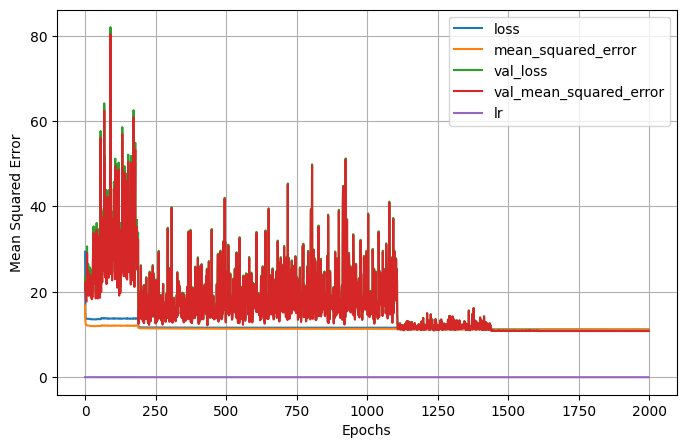

In [8]:
plot_model_history(history)

# 6. Save model and description

In [9]:
description = f"# Neural network architecture hyperparameters \n\
input_size = train_features[0].shape \n\
output_size = len(train_labels[0]) \n\
hidden_layer_sizes = [1024, 512, 256, 64, 32] \n\
regularizer = keras.regularizers.L1L2(l1=0.001,l2=0.1) \n\
hidden_activation = 'relu' \n\
output_activation = 'linear' \n\
use_batch_normalization = True \n\
name = 'LinearSurfaceReconstructor' \n\
# Compilation hyperparameters \n\
loss_function = tf.keras.losses.MeanSquaredError() \n\
learning_rate = 0.01 \n\
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999) \n\
metric = tf.keras.metrics.MeanSquaredError() \n\
# Training hyperparameters \n\
epochs = 2000 \n\
batch_size = 64 \n\
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=150, verbose=1) \n\
early_stop = EarlyStopping('mean_squared_error', patience=500, verbose=1) \n\
callbacks = [reduce_lr, early_stop]"

store_model(surface_reconstructor_model,
            name,
            description)